In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import spacy
import string
import re
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from spacy.symbols import ORTH
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import os

directory = os.getcwd()
print(directory)

/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cols= ['target', 'id', 'date', 'flag', 'user', 'text']
chunk_size = 10000  # Adjust the size as needed
chunks = pd.read_csv('./training.tweets.processed.csv', encoding='ISO-8859-1', header=None, names=cols, chunksize=chunk_size)
data = pd.concat(chunks, ignore_index=True)

In [9]:
data.tail(5)

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [10]:
print(data[data['text'].isnull() == True])

Empty DataFrame
Columns: [target, id, date, flag, user, text]
Index: []


In [11]:
data.shape

(1600000, 6)

In [12]:
data['text'][1599996]

'TheWDB.com - Very cool to hear old Walt interviews!  â\x99« http://blip.fm/~8bmta'

In [13]:
data['target'].unique()

array([0, 4])

In [14]:
cols_to_drop = ['id', 'date', 'flag', 'user']
data2= data.drop(columns= cols_to_drop, axis = 1)

In [15]:
data2['text'] = data2['text'].astype(str)

In [16]:
data2['text'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## label encoding for the target value

In [17]:
data2['target'] = [0 if label == 0 else 1 for label in data['target']]

In [18]:
data2['target'].unique()

array([0, 1])

In [19]:
len(data2)

1600000

In [20]:
data2['text'] = data2['text'].dropna()

In [21]:
len(data2)

1600000

## check for imbalanced dataset
### by looking at the sentiment distribution chart below, both target values are equally distributed. We do not have an imbalanced dataset.

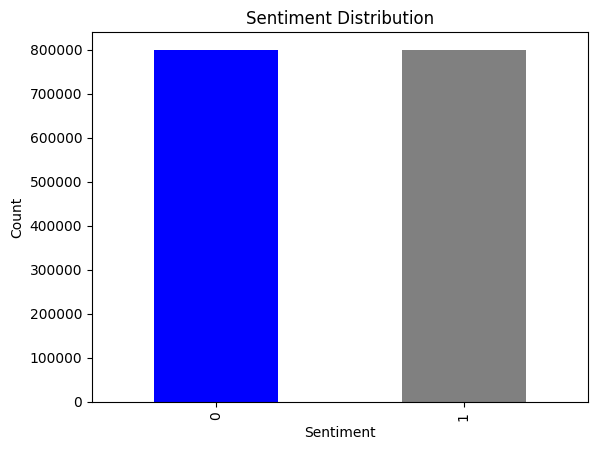

In [22]:
import matplotlib.pyplot as plt
label_counts= pd.Series(data2['target']).value_counts()
label_counts.plot(kind= 'bar', color = ['blue', 'gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## text cleaning

In [ ]:
#text_cleaning = re.compile(r'|((@\w+) | (http\S+)|([^a-zA-Z0-9\s]|(\s+))', re.IGNORECASE)

In [23]:
re_text = re.compile(r'(@\w+)|(http\S+)', re.IGNORECASE)
def sub_br(x): return re_text.sub("a", x)

In [24]:
#!python -m spacy download en_core_web_sm

In [25]:
my_tok= spacy.load('en_core_web_sm')

In [26]:
def my_tokenization(x):
    if isinstance(x, str):
        cleaned_text = sub_br(x)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        return [tok.text for tok in my_tok.tokenizer(cleaned_text)]
    elif pd.notna(x):  # Check for non-null values
        cleaned_text = sub_br(str(x))
        return [tok.text for tok in my_tok.tokenizer(cleaned_text)]


In [27]:
check = data2['text'].tolist()

In [28]:
check[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [29]:
min_sentence = data2['text'].apply(lambda x: len(x))

## Computing vocab2index

In [30]:
#%config Z
#MQInteractiveShell.iopub_data_rate_limit=1000000000

In [31]:
counts = Counter()
counts.update(data2['text'].apply(lambda x: my_tokenization(x)).explode())

In [32]:
first_key = next(iter(counts))
first_value = counts[first_key]

In [33]:
first_key, first_value

('a', 1221402)

In [34]:
len(counts.keys())

458441

## let's remove fillers

In [35]:
for word in list(counts):
  if counts[word] < 5:
    del counts[word]

In [36]:
len(counts.keys())

72948

In [37]:
counts

Counter({'a': 1221402,
         '-': 119855,
         'Awww': 1892,
         ',': 482706,
         'that': 155269,
         "'s": 178914,
         'bummer': 1001,
         '.': 804972,
         'You': 26331,
         'shoulda': 298,
         'got': 61423,
         'David': 1684,
         'Carr': 39,
         'of': 180640,
         'Third': 97,
         'Day': 5472,
         'to': 557894,
         'do': 122142,
         'it': 260572,
         ';D': 736,
         'is': 232135,
         'upset': 2552,
         'he': 31956,
         'ca': 52627,
         "n't": 170855,
         'update': 4024,
         'his': 14819,
         'Facebook': 1398,
         'by': 24506,
         'texting': 686,
         '...': 219948,
         'and': 281801,
         'might': 8696,
         'cry': 4285,
         'as': 37076,
         'result': 569,
         'School': 1327,
         'today': 63078,
         'also': 8016,
         'Blah': 392,
         '!': 903976,
         'I': 658549,
         'many': 8420,
    

## data processing

In [38]:
vocab2index = {"": 0, "UNK": 1}
words = ["", "UNK"]
for word in counts:
  vocab2index[word] = len(words)
  words.append(word)

In [39]:
list(vocab2index.items())[0]

('', 0)

In [40]:
enc= np.zeros(150, dtype = np.int32)
enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [41]:
data2['text'][2]

'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

In [42]:
x = my_tokenization(data2['text'][2])

In [43]:
x

['a',
 'I',
 'dived',
 'many',
 'times',
 'for',
 'the',
 'ball',
 '.',
 'Managed',
 'to',
 'save',
 '50',
 '%',
 'The',
 'rest',
 'go',
 'out',
 'of',
 'bounds']

In [44]:
encl = [vocab2index.get(w, vocab2index["UNK"]) for w in x]

In [45]:
encl[3]

44

In [46]:
def encode_sentence(text, vocab2index, N = 400, padding_start = True):
 # if not text:
 #   return np.zeros(N, dtype= np.int32), 0
  x = my_tokenization(text)
  enc = np.zeros(N, dtype = np.int32)
  encl = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in x])
  length = min(N, len(encl))
  if padding_start:
    enc[: length] = encl[: length]
  else:
    enc[N - length: ] = encl[: length]
  return enc, length

check if the function works

In [47]:
data2.columns

Index(['target', 'text'], dtype='object')

In [48]:
text = data2['text'][3]
encode_sentence(text, vocab2index, N= 400, padding_start = True)

(array([58, 59, 60, 61, 62, 33, 63, 64, 65, 66,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [49]:
check2 = list(data2['text'].items())
check2[2]

(2,
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds')

In [50]:
class TwitterDataset(Dataset):
  def __init__(self, data, N = 400, padding_start = True):
    self.data = data2
    self.y = self.data['target']
    self.files = list(self.data['text'].items())
    self.X = [encode_sentence(text, vocab2index, N , padding_start ) for text in self.files]

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    x, s= self.X[idx]

    return x, s, self.y.iloc[idx]

In [51]:
train_data, valid_data = train_test_split(data2, test_size = 0.2, random_state = 42 )

In [137]:
class LSTMModel(torch.nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.dropout = nn.Dropout(0.5)
    self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True)
    self.linear = nn.Linear(hidden_dim, 1)

  def forward(self, x, s):
    s, sort_index = torch.sort(s, 0, descending = True)
    s = s.cpu().numpy().tolist()
    x = x[sort_index]
    x = self.embeddings(x)
    x = self.dropout(x)

    x_pack = pack_padded_sequence(x, s, batch_first = True)
    out_pack, (ht, ct) = self.lstm(x_pack)
    out = self.linear(ht[-1])
    return torch.zeros_like(out).scatter_(0, sort_index.unsqueeze(1).cuda(), out)

In [53]:
def train_epochs(model, epochs = 10, lr = 0.001):
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = torch.optim.Adam(parameters, lr = lr)
  for i in range(epochs):
    model.train()
    sum_loss = 0.0
    total = 0
    for x, s, y in train_dl:
      x = x.long().cuda()
      y = y.float().cuda()
     # x, s, y = x, s, y
      y_pred = model(x, s)
      optimizer.zero_grad()
      loss = F.binary_cross_entropy_with_logits(y_pred, y.unsqueeze(1))
      loss.backward()
      optimizer.step()
      sum_loss += loss.item() * y.shape[0]
      total += y.shape[0]
    val_loss, val_acc = val_metrics(model, valid_dl)
    if i % 5 == 1:
      print("train loss %.3f val loss %.3f val_accuracy %.3f" % (sum_loss / total, val_loss, val_acc))

In [54]:
def val_metrics(model, valid_dl):
  model.eval()
  correct = 0
  total = 0
  sum_loss = 0.0
  for x, s, y in valid_dl:
    x = x.long().cuda()
    y = y.float().unsqueeze(1).cuda()
    y_hat = model(x, s)
    loss = F.binary_cross_entropy_with_logits(y_hat, y)
    y_pred = y_hat >0
    correct += (y_pred.float() == y).float().sum()
    total += y.shape[0]
    sum_loss += loss.item() * y.shape[0]
  return sum_loss/ total, correct / total


In [ ]:
train_ds = TwitterDataset(train_data)
valid_ds = TwitterDataset(valid_data)

In [56]:
train_ds[9]

(array([ 284, 4123,    5,  144,    2,  103,  104,    1,   78,  144,  285,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

## Debugging

In [57]:
idx = 0
text =  data2['text'].iloc[idx]
#print(text)
x, s= encode_sentence(text, vocab2index , N = 400, padding_start = False)
print(s)
print(x)

23
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [58]:
batch_size = 7
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
x, s, y = next(iter(train_dataloader))

In [59]:
x.shape, s.shape

(torch.Size([7, 400]), torch.Size([7]))

In [60]:
s

tensor([35, 24, 21, 20, 18, 12, 31])

In [61]:
y

tensor([0, 0, 0, 1, 0, 0, 0])

In [62]:
#sort by length so we can use pack_padded_sequence
s, index = s.sort(0, descending = True)
x = x[index]

In [63]:
x.shape

torch.Size([7, 400])

In [64]:
index

tensor([0, 6, 1, 2, 3, 4, 5])

In [65]:
y[index]

tensor([0, 0, 0, 0, 1, 0, 0])

In [66]:
vocab_size = len(words)
embedding_dim = 10
embed = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)

In [67]:
x = embed(x.long())
x.shape

torch.Size([7, 400, 10])

In [68]:
hidden_dim = 9
lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

In [69]:
x_pack = pack_padded_sequence(x, list(s), batch_first = True)
x_pack = x_pack.to(torch.float)

In [70]:
out_pack, (ht, ct) = lstm(x_pack)

In [71]:
ht.shape

torch.Size([1, 7, 9])

In [72]:
ht[-1].shape

torch.Size([7, 9])

In [73]:
linear = nn.Linear(hidden_dim, 1)
y_hat = linear(ht[-1])
y_hat

tensor([[0.3254],
        [0.3068],
        [0.3142],
        [0.3323],
        [0.3290],
        [0.2869],
        [0.3084]], grad_fn=<AddmmBackward0>)

In [74]:
index.unsqueeze(1).shape

torch.Size([7, 1])

In [75]:
#takes back to the original ordering
h = torch.zeros_like(y_hat).scatter_(0, index.unsqueeze(1), y_hat)


In [76]:
h

tensor([[0.3254],
        [0.3142],
        [0.3323],
        [0.3290],
        [0.2869],
        [0.3084],
        [0.3068]], grad_fn=<ScatterBackward0>)

In [77]:
index

tensor([0, 6, 1, 2, 3, 4, 5])

In [78]:
batch_size = 3000
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size= batch_size)

In [138]:
vocab_size = len(words)
print(vocab_size)
model = LSTMModel(vocab_size, 50, 50).cuda()

72950


In [80]:
train_epochs(model , epochs = 30, lr = 0.01)

train loss 0.390 val loss 0.352 val_accuracy 0.846
train loss 0.336 val loss 0.306 val_accuracy 0.869
train loss 0.319 val loss 0.288 val_accuracy 0.878
train loss 0.309 val loss 0.277 val_accuracy 0.883
train loss 0.303 val loss 0.268 val_accuracy 0.888
train loss 0.298 val loss 0.265 val_accuracy 0.889


##Gated Recurrent Unit with dropout

In [131]:
class GRUModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first = True)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, x, s):
        s, sort_index = torch.sort(s, 0, descending = True)
        s = s.cpu().numpy().tolist()
        x = x[sort_index]
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first = True)
        out_pack, ht = self.gru(x_pack)
        out = self.linear(ht[-1])
        return torch.zeros_like(out).scatter_(0, sort_index.unsqueeze(1).cuda(), out)


In [132]:
vocab_size = len(words)
print(vocab_size)
modelGRU = GRUModel(vocab_size, 50, 50).cuda()

72950


In [83]:
train_epochs(modelGRU, epochs = 30, lr = 0.01)

train loss 0.390 val loss 0.351 val_accuracy 0.847
train loss 0.342 val loss 0.313 val_accuracy 0.866
train loss 0.330 val loss 0.302 val_accuracy 0.872
train loss 0.326 val loss 0.297 val_accuracy 0.874
train loss 0.325 val loss 0.295 val_accuracy 0.875
train loss 0.332 val loss 0.300 val_accuracy 0.872


Model Performance Evaluations

In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
valid_dl = DataLoader(valid_ds, batch_size= batch_size, pin_memory = True, num_workers= 2)

In [134]:
def threshold_predictions(out, threshold = 0.5):
  return (out > threshold).float()

def evaluate_metrics(model, valid_dl, threshold= 0.5):
  model.eval()
  all_predictions = []
  all_labels = []

  with torch.no_grad():
    for x, s, y in valid_dl:
      x, s, y = x.to(device), s.to(device), y.to(device)
      logits = model(x, s)
      predictions = threshold_predictions(logits, threshold)
      all_predictions.extend(predictions.cpu().numpy())
      all_labels.extend(y.cpu().numpy())
  all_predictions = torch.tensor(all_predictions).to(device)
  all_labels = torch.tensor(all_labels).to(device)

  threshold = torch.FloatTensor([threshold]).to(device)
  binary_predictions = (all_predictions) > threshold.long()
  binary_labels = (all_labels > 0.5).long()

  precision = precision_score(binary_labels.cpu().numpy(), binary_predictions.cpu().numpy(), zero_division = 1)
  recall = recall_score(binary_labels.cpu().numpy(), binary_predictions.cpu().numpy())
  f1 = f1_score(binary_labels.cpu().numpy(), binary_predictions.cpu().numpy())
  return precision, recall, f1



In [ ]:
precision, recall, f1 = evaluate_metrics(model, valid_dl)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

